## linear policy evaluation

In [7]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from itertools import count
from collections import namedtuple, deque
from tqdm import tqdm
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


env = gym.make("CartPole-v1")

feature_dim = 128

class feature_mapping(nn.Module):
    def __init__(self, n_observations, feature_dim, feature_bd = 1, device = device):
        super().__init__()
        torch.manual_seed(0)
        self.input_size = n_observations
        self.feature_dim = feature_dim
        self.device = device
        self.centers = torch.randn(self.input_size, self.feature_dim).to(self.device) / feature_bd
        self.bias = torch.rand(self.feature_dim).to(self.device) * 2 * np.pi
        self.centers[:,0] *= 0
        self.bias[0] *= 0
    def forward(self, x):
        return torch.cos(torch.matmul(x,self.centers) + self.bias) / self.feature_dim ** 0.5
    
class Linear_model(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(Linear_model, self).__init__()
        self.feature_mapping = feature_mapping(n_observations, feature_dim, device=device)
        self.linear = nn.Linear(feature_dim, n_actions, bias=False)           

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = self.feature_mapping(x)
        x = self.linear(x)
        return x
    
    def init(self):
        nn.init.zeros_(self.linear.weight)
        
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)
DQN_net = DQN(env.observation_space.shape[0], env.action_space.n).to(device)

# Load the trained model weights
DQN_net.load_state_dict(torch.load("policy_net.pth", weights_only=True))


def policy_DQN(state):
    if not isinstance(state, torch.Tensor):
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    actions = DQN_net(state)
    action = actions.max(1)[1].view(1, 1)
    return action
    

def policy_uniform(state):
    return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

In [8]:
print(torch.cuda.is_available())
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)
policy_net = Linear_model(n_observations, n_actions).to(device)

True


In [9]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [10]:
memory = ReplayMemory(10000)
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    
    # Get next actions using policy_DQN
    next_actions = torch.tensor([
        policy_DQN(state.unsqueeze(0)).item() 
        for state in non_final_next_states
    ], device=device).unsqueeze(1)

# Get Q-values for policy-selected actions
    next_q_values = policy_net(non_final_next_states)
    next_state_values[non_final_mask] = next_q_values.gather(1, next_actions).squeeze()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    
    criterion = nn.MSELoss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [11]:
import matplotlib
import matplotlib.pyplot as plt
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

def plot_loss(show_result=False):
    plt.figure(1)
    loss_t = torch.tensor(episode_loss, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.plot(loss_t.numpy())
    # Take 100 episode averages and plot them too
    # if len(durations_t) >= 100:
    #     means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
    #     means = torch.cat((torch.zeros(99), means))
    #     plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.clear_output(wait=True)
            display.display(plt.gcf())
        else:
            display.display(plt.gcf())
    else:
        plt.draw()
        plt.pause(0.001)
def calculate_loss(policy_net, DQN_net):
    # Calculate the loss
    loss = 0
    for i in range(100):
        state, info = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        loss += F.mse_loss(policy_net(state), DQN_net(state))
    return loss / 100

  1%|          | 1/100 [00:04<07:35,  4.60s/it]

8390.75


  2%|▏         | 2/100 [00:15<13:41,  8.38s/it]

8386.8603515625


  3%|▎         | 3/100 [00:26<15:20,  9.49s/it]

8388.8232421875


  4%|▍         | 4/100 [00:33<13:43,  8.58s/it]

8405.826171875


  5%|▌         | 5/100 [00:45<15:31,  9.81s/it]

8397.5615234375


  6%|▌         | 6/100 [00:53<14:33,  9.30s/it]

8427.7021484375


  7%|▋         | 7/100 [01:02<14:01,  9.05s/it]

8450.6240234375


  8%|▊         | 8/100 [01:12<14:22,  9.37s/it]

8368.275390625


  9%|▉         | 9/100 [01:21<13:53,  9.16s/it]

8407.9130859375


 10%|█         | 10/100 [01:29<13:19,  8.88s/it]

8335.271484375


 11%|█         | 11/100 [01:36<12:30,  8.44s/it]

8455.234375


 12%|█▏        | 12/100 [01:47<13:16,  9.05s/it]

8388.5458984375


 13%|█▎        | 13/100 [01:58<13:56,  9.61s/it]

8382.3037109375


 14%|█▍        | 14/100 [02:06<12:58,  9.06s/it]

8445.9013671875


 15%|█▌        | 15/100 [02:21<15:27, 10.91s/it]

8337.564453125


 16%|█▌        | 16/100 [02:28<13:56,  9.96s/it]

8428.236328125


 17%|█▋        | 17/100 [02:37<13:08,  9.50s/it]

8351.6650390625


 18%|█▊        | 18/100 [02:48<13:39, 10.00s/it]

8317.1904296875


 19%|█▉        | 19/100 [02:58<13:27,  9.97s/it]

8367.27734375


 20%|██        | 20/100 [03:05<12:12,  9.16s/it]

8318.5673828125


 21%|██        | 21/100 [03:18<13:24, 10.19s/it]

8334.6044921875


 22%|██▏       | 22/100 [03:25<12:04,  9.29s/it]

8321.0283203125


 23%|██▎       | 23/100 [03:32<10:51,  8.47s/it]

8360.849609375


 24%|██▍       | 24/100 [03:39<10:15,  8.10s/it]

8363.896484375


 25%|██▌       | 25/100 [03:46<09:42,  7.76s/it]

8349.3408203125


 26%|██▌       | 26/100 [03:54<09:33,  7.75s/it]

8302.5419921875


 27%|██▋       | 27/100 [04:07<11:37,  9.56s/it]

8321.5810546875


 28%|██▊       | 28/100 [04:16<10:59,  9.16s/it]

8375.107421875


 29%|██▉       | 29/100 [04:24<10:25,  8.81s/it]

8351.9287109375


 30%|███       | 30/100 [04:31<09:50,  8.44s/it]

8337.1376953125


 31%|███       | 31/100 [04:40<09:48,  8.52s/it]

8358.5810546875


 32%|███▏      | 32/100 [04:48<09:27,  8.35s/it]

8258.2001953125


 33%|███▎      | 33/100 [04:56<09:11,  8.24s/it]

8329.6123046875


 34%|███▍      | 34/100 [05:04<08:56,  8.13s/it]

8307.9189453125


 35%|███▌      | 35/100 [05:12<08:57,  8.27s/it]

8320.9755859375


 36%|███▌      | 36/100 [05:20<08:33,  8.02s/it]

8307.16796875


 37%|███▋      | 37/100 [05:28<08:29,  8.09s/it]

8242.7900390625


 38%|███▊      | 38/100 [05:38<08:58,  8.69s/it]

8259.017578125


 39%|███▉      | 39/100 [05:48<09:06,  8.96s/it]

8280.8310546875


 40%|████      | 40/100 [05:57<09:01,  9.03s/it]

8294.802734375


 41%|████      | 41/100 [06:04<08:28,  8.61s/it]

8342.82421875


 42%|████▏     | 42/100 [06:14<08:28,  8.77s/it]

8312.4501953125


 43%|████▎     | 43/100 [06:21<07:54,  8.33s/it]

8302.267578125


 44%|████▍     | 44/100 [06:29<07:36,  8.15s/it]

8284.861328125


 45%|████▌     | 45/100 [06:37<07:31,  8.20s/it]

8267.3564453125


 46%|████▌     | 46/100 [06:46<07:40,  8.53s/it]

8291.625


 47%|████▋     | 47/100 [06:55<07:38,  8.66s/it]

8295.30078125


 48%|████▊     | 48/100 [07:05<07:42,  8.90s/it]

8292.4384765625


 49%|████▉     | 49/100 [07:12<07:15,  8.55s/it]

8215.7333984375


 50%|█████     | 50/100 [07:27<08:44, 10.48s/it]

8243.193359375


 51%|█████     | 51/100 [07:34<07:40,  9.39s/it]

8254.9853515625


 52%|█████▏    | 52/100 [07:42<07:11,  9.00s/it]

8346.7255859375


 53%|█████▎    | 53/100 [07:49<06:33,  8.36s/it]

8281.8388671875


 54%|█████▍    | 54/100 [07:57<06:15,  8.17s/it]

8279.154296875


 55%|█████▌    | 55/100 [08:06<06:14,  8.31s/it]

8236.251953125


 56%|█████▌    | 56/100 [08:13<05:55,  8.09s/it]

8226.220703125


 57%|█████▋    | 57/100 [08:20<05:38,  7.86s/it]

8260.876953125


 58%|█████▊    | 58/100 [08:29<05:33,  7.94s/it]

8275.552734375


 59%|█████▉    | 59/100 [08:36<05:20,  7.82s/it]

8235.75


 60%|██████    | 60/100 [08:51<06:34,  9.85s/it]

8285.32421875


 61%|██████    | 61/100 [08:59<06:03,  9.31s/it]

8276.6396484375


 62%|██████▏   | 62/100 [09:13<06:52, 10.85s/it]

8216.36328125


 63%|██████▎   | 63/100 [09:22<06:24, 10.38s/it]

8217.8837890625


 64%|██████▍   | 64/100 [09:30<05:45,  9.59s/it]

8292.6337890625


 65%|██████▌   | 65/100 [09:39<05:24,  9.27s/it]

8214.7490234375


 66%|██████▌   | 66/100 [09:53<06:08, 10.85s/it]

8248.9638671875


 67%|██████▋   | 67/100 [10:01<05:26,  9.90s/it]

8252.431640625


 68%|██████▊   | 68/100 [10:10<05:09,  9.66s/it]

8199.80078125


 69%|██████▉   | 69/100 [10:19<04:49,  9.35s/it]

8246.2392578125


 70%|███████   | 70/100 [10:26<04:18,  8.61s/it]

8258.3349609375


 71%|███████   | 71/100 [10:36<04:23,  9.08s/it]

8257.560546875


 72%|███████▏  | 72/100 [10:45<04:19,  9.28s/it]

8263.837890625


 73%|███████▎  | 73/100 [11:03<05:16, 11.72s/it]

8222.9755859375


 74%|███████▍  | 74/100 [11:14<05:03, 11.67s/it]

8210.3369140625


 75%|███████▌  | 75/100 [11:22<04:21, 10.45s/it]

8183.52880859375


 76%|███████▌  | 76/100 [11:33<04:17, 10.73s/it]

8186.2060546875


 77%|███████▋  | 77/100 [11:47<04:22, 11.43s/it]

8227.951171875


 78%|███████▊  | 78/100 [11:55<03:54, 10.68s/it]

8164.14990234375


 79%|███████▉  | 79/100 [12:06<03:41, 10.55s/it]

8212.00390625


 80%|████████  | 80/100 [12:14<03:20, 10.01s/it]

8202.328125


 81%|████████  | 81/100 [12:23<02:59,  9.45s/it]

8287.171875


 82%|████████▏ | 82/100 [12:35<03:06, 10.34s/it]

8162.912109375


 83%|████████▎ | 83/100 [12:44<02:49,  9.99s/it]

8135.01904296875


 84%|████████▍ | 84/100 [12:52<02:29,  9.36s/it]

8196.9267578125


 85%|████████▌ | 85/100 [12:59<02:11,  8.74s/it]

8140.552734375


 86%|████████▌ | 86/100 [13:07<01:58,  8.47s/it]

8203.6083984375


 87%|████████▋ | 87/100 [13:18<02:00,  9.30s/it]

8209.5087890625


 88%|████████▊ | 88/100 [13:27<01:50,  9.23s/it]

8189.54541015625


 89%|████████▉ | 89/100 [13:35<01:34,  8.58s/it]

8155.88623046875


 90%|█████████ | 90/100 [13:44<01:27,  8.71s/it]

8135.91650390625


 91%|█████████ | 91/100 [13:53<01:19,  8.79s/it]

8171.39599609375


 92%|█████████▏| 92/100 [14:01<01:10,  8.76s/it]

8169.982421875


 93%|█████████▎| 93/100 [14:11<01:03,  9.07s/it]

8124.18212890625


 94%|█████████▍| 94/100 [14:21<00:56,  9.46s/it]

8176.90478515625


 95%|█████████▌| 95/100 [14:31<00:47,  9.53s/it]

8104.43310546875


 96%|█████████▌| 96/100 [14:39<00:35,  8.96s/it]

8086.86962890625


 97%|█████████▋| 97/100 [14:48<00:26,  8.95s/it]

8187.0390625


 98%|█████████▊| 98/100 [15:04<00:22, 11.10s/it]

8147.66357421875


 99%|█████████▉| 99/100 [15:12<00:10, 10.27s/it]

8156.74658203125


100%|██████████| 100/100 [15:22<00:00,  9.23s/it]

8144.5556640625
Complete


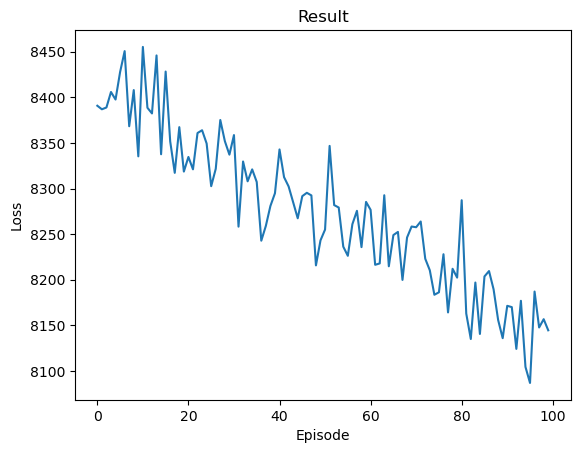

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [12]:
num_episodes = 100
episode_loss = []
for i_episode in tqdm(range(num_episodes)):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = policy_DQN(state) # on policy evaluation
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()
        if done:
            loss = calculate_loss(policy_net, DQN_net).item()
            episode_loss.append(loss)
            print(loss)
            # plot_loss()
            break
    
print('Complete')
plot_loss(show_result=True)
plt.ioff()
plt.show()


In [13]:
from numpy import argmax


state, info = env.reset()
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
print(DQN_net(state).argmax())
print(policy_net(state).argmax())


tensor(1, device='cuda:0')
tensor(1, device='cuda:0')


In [14]:
print(loss)


8144.5556640625
